### Install project

In [7]:
!git clone https://github.com/kornelro/cv_project.git

Cloning into 'cv_project'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (420/420), done.
remote: Compressing objects: 100% (290/290), done.
remote: Total 698 (delta 156), reused 260 (delta 71), pack-reused 278
Receiving objects: 100% (698/698), 103.86 MiB | 37.29 MiB/s, done.
Resolving deltas: 100% (302/302), done.


In [8]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=16507 sha256=077c23b10a78e10c27728f162ee6f7ad92d4b472d8e84aa198dea7b29822cc18
  Stored in directory: /tmp/pip-ephem-wheel-cache-6f66olnh/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src
  Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0


### Mount drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [12]:
import pickle
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.data.make_dataset import make_dataset
from src.data.image_loaders import OrtoFixedSizeImageLoader
from src.data.dataset_loaders import OrtoDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow
from src.evaluation import validate_model, precision, recall, f1_score

# Orto
# ResNet50
# Pipeline: Norm

### Load dataset

In [13]:
DATA_PATH = DRIVE_PATH+'data/processed/aerial-cars-dataset/resnet/data_resnet.pickle'

In [14]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### Train ResNet50

In [15]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 1

In [16]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


input_t = K.Input(shape=(X[0].shape))
res_model = K.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t
)

for layer in res_model.layers:
    layer.trainable = False

model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='softmax'))


model.compile(
    optimizer=K.optimizers.Adam(0.001),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

43/43 [==============================] - 9s 88ms/step - loss: 0.2762 - accuracy: 0.9188 - val_loss: 0.0894 - val_accuracy: 0.9809


### Validation

In [19]:
data = None

In [20]:
BND_BOX_SIZE = (80, 80)
STEP_SIZE = 20

dataset_loader = OrtoDatasetLoader(
    image_loader=OrtoFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

treshold = 0.9; nms_overlap=0.4

In [26]:
processed_images = None

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/orto/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/orto/norm/t9nms4',
    images_files_types=('png',),
    annotations_files_types=('json',),
    detector=slider_detector,
    workers=0
)


print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

  0%|          | 0/5 [00:00<?, ?it/s]

425


 40%|████      | 2/5 [00:27<00:40, 13.66s/it]

123
451


 60%|██████    | 3/5 [00:40<00:27, 13.61s/it]

364


 80%|████████  | 4/5 [00:54<00:13, 13.57s/it]

504


100%|██████████| 5/5 [01:07<00:00, 13.54s/it]



Precision: 0.073
Recall: 0.098
F1Score: 0.084


In [17]:
from src.data.make_dataset import make_dataset

In [21]:
data = dataset_loader.load_dataset(
    input_folder_filepath=DRIVE_PATH+'data/raw/orto/val_dev',
    images_files_types=('png',),
    annotations_files_types=('json',)
)

100%|██████████| 2/2 [00:00<00:00, 12.71it/s]


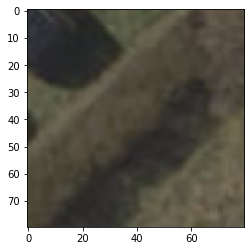

In [24]:
plt.imshow(data[0].get_car(data[0].bnd_boxes[1]))

treshold = 0.95; nms_overlap=0.4

In [ ]:
processed_images = None

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.95,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/orto/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/orto/norm/t95nms4',
    images_files_types=('png',),
    annotations_files_types=('json',),
    detector=slider_detector,
    workers=0
)


print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

 11%|█         | 1/9 [00:04<00:38,  4.85s/it]

190


 22%|██▏       | 2/9 [00:09<00:33,  4.82s/it]

212


 33%|███▎      | 3/9 [00:14<00:28,  4.81s/it]

48


 44%|████▍     | 4/9 [00:19<00:24,  4.80s/it]

46


 56%|█████▌    | 5/9 [00:23<00:19,  4.80s/it]

247


 67%|██████▋   | 6/9 [00:45<00:29,  9.71s/it]

107


 78%|███████▊  | 7/9 [00:49<00:16,  8.23s/it]

228


 89%|████████▉ | 8/9 [00:54<00:07,  7.19s/it]

179


100%|██████████| 9/9 [00:59<00:00,  6.60s/it]

155



Precision: 0.277
Recall: 0.85
F1Score: 0.418


treshold = 0.98; nms_overlap=0.4

In [ ]:
processed_images = None

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.3
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/orto/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/orto/norm/t98nms4',
    images_files_types=('png',),
    annotations_files_types=('json',),
    detector=slider_detector,
    workers=0
)


print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

 11%|█         | 1/9 [00:06<00:52,  6.55s/it]

183


 22%|██▏       | 2/9 [00:11<00:41,  5.98s/it]

217


 33%|███▎      | 3/9 [00:15<00:33,  5.60s/it]

54


 44%|████▍     | 4/9 [00:20<00:26,  5.32s/it]

46


 56%|█████▌    | 5/9 [00:25<00:20,  5.13s/it]

238
129


 78%|███████▊  | 7/9 [00:56<00:19,  9.51s/it]

224


 89%|████████▉ | 8/9 [01:01<00:08,  8.10s/it]

188


100%|██████████| 9/9 [01:06<00:00,  7.35s/it]

148



Precision: 0.287
Recall: 0.69
F1Score: 0.405


treshold = 0.9; nms_overlap=0.5

In [ ]:
processed_images = None

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.5
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/aerial-cars-dataset/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/aerial-cars-dataset/norm/t9nms5',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)


print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

 11%|█         | 1/9 [00:06<00:49,  6.19s/it]

188


 22%|██▏       | 2/9 [00:10<00:39,  5.71s/it]

253


 33%|███▎      | 3/9 [00:15<00:32,  5.38s/it]

50


 44%|████▍     | 4/9 [00:19<00:25,  5.14s/it]

45


 56%|█████▌    | 5/9 [00:24<00:19,  4.98s/it]

244
159


 78%|███████▊  | 7/9 [00:55<00:18,  9.44s/it]

241


 89%|████████▉ | 8/9 [01:00<00:08,  8.06s/it]

187


100%|██████████| 9/9 [01:05<00:00,  7.28s/it]

159



Precision: 0.257
Recall: 0.867
F1Score: 0.396
